In [ ]:
from dotenv import load_dotenv
from langchain_core.documents import Document
from langchain_community.vectorstores import Qdrant
from langchain.text_splitter import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import yagmail
import os

load_dotenv()

def load_txt_as_documents(txt_file):
    with open(txt_file, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text


raw_text = load_txt_as_documents(r"C:\Users\FINE LAPTOP\Desktop\Langchain\langgraph\rag_service.txt")
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_text(raw_text)
documents = [Document(page_content=chunk) for chunk in texts]


embedding_function = OpenAIEmbeddings()


qdrant_client = QdrantClient(host="localhost", port=6333)

qdrant_client.recreate_collection(
    collection_name="rag_txt_collection",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)


db = Qdrant(
    client=qdrant_client,
    collection_name="rag_txt_collection",
    embeddings=embedding_function
)


db.add_documents(documents)

print("Uploaded documents to running Docker Qdrant.")


class GraphState(TypedDict):
    question: str
    context: str
    answer: str
    recipient: str

def send_email(state: GraphState):
    recipient = state.get("recipient")
    subject = f"Response to your query: {state['question'][:50]}"
    body = state["answer"]

    try:
        yag = yagmail.SMTP(user=os.getenv("EMAIL_USER"), password=os.getenv("EMAIL_PASSWORD"))
        yag.send(to=recipient, subject=subject, contents=body)
        print(f"Email sent to {recipient}")
    except Exception as e:
        print(f"Failed to send email: {e}")
    
    return state 

llm = ChatOpenAI(model="gpt-3.5-turbo")


def retrieve(state: GraphState):
    query = state["question"]
    retriever = db.as_retriever()
    docs = retriever.invoke(query)
    context = "\n\n".join([doc.page_content for doc in docs])
    return {"question": query, "context": context}


def generate(state: GraphState):
    prompt = f"""Answer the question using this context:\n\n{state['context']}\n\nQuestion: {state['question']}"""
    response = llm.invoke(prompt)
    return {
        "question": state["question"],
        "context": state["context"],
        "answer": response.content
    }
graph = StateGraph(GraphState)
graph.add_node("retrieve", RunnableLambda(retrieve))
graph.add_node("generate", RunnableLambda(generate))
graph.add_node("send_email", RunnableLambda(send_email))  

graph.set_entry_point("retrieve")
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", "send_email")  
graph.add_edge("send_email", END)

app = graph.compile()

inputs = {
    "question": "I have an issue setting a different delivery address up",
    "recipient": "shahzain0066@gmail.com"
}

result = app.invoke(inputs)

print("Final Answer:", result["answer"])



Uploaded documents to running Docker Qdrant.
Email sent to shahzain0066@gmail.com
Final Answer: Answer: It seems like you're encountering difficulties when trying to set up a different delivery address. I understand the importance of this task and am here to assist you. To resolve this issue, please follow these steps:

1. Log in to your account.
2. Go to the 'Shipping' or 'Delivery' section.
3. Look for the option to 'Add New Address' or 'Edit Address'.
4. Enter the details of the different delivery address you want to set up.
5. Verify the accuracy of the entered information.
6. Save the changes.

If you encounter any obstacles during this process or have any further questions, please don't hesitate to reach out. I'm here to help you with setting up your new delivery address.


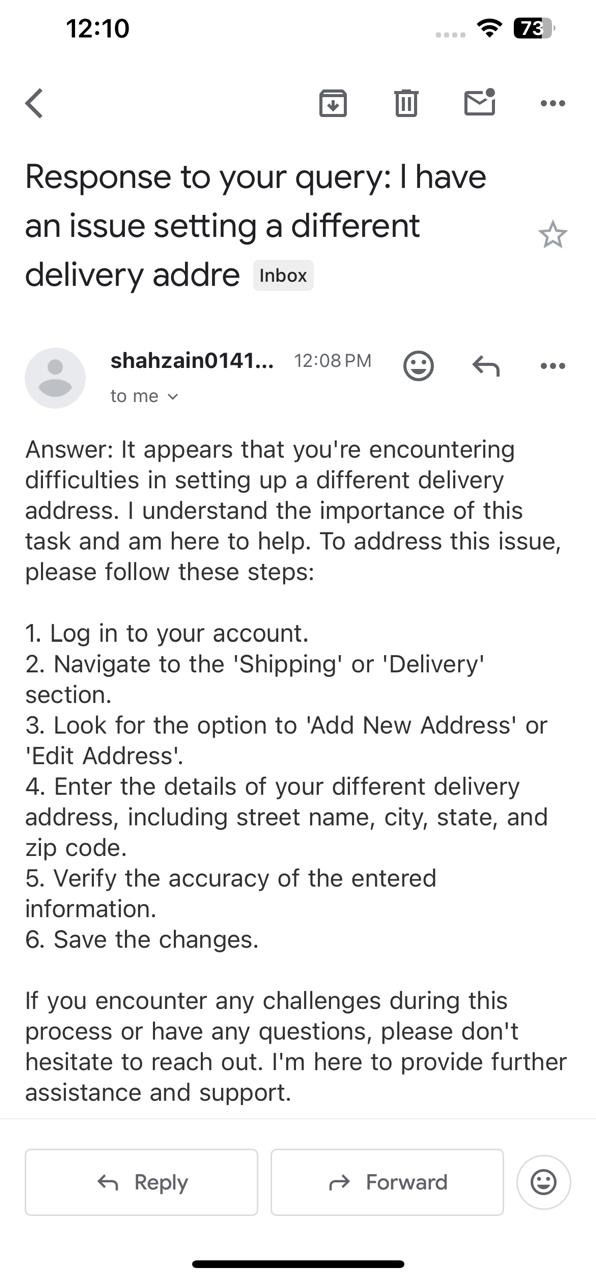

In [2]:

from PIL import Image
from IPython.display import display


img_path = "WhatsApp Image 2025-07-25 at 12.10.39 PM.jpeg"
image = Image.open(img_path)
display(image)
